# The Kolmogorov Forward Equation (Fokker-Planck Equation)

## Introduction

The **Kolmogorov Forward Equation**, also known as the **Fokker-Planck Equation**, is a fundamental partial differential equation in the theory of stochastic processes. It describes the time evolution of the probability density function of a stochastic process, providing a deterministic description of inherently random phenomena.

This equation finds applications across physics (Brownian motion, statistical mechanics), finance (option pricing, risk modeling), biology (population dynamics), and engineering (noise analysis, signal processing).

## Mathematical Foundation

### The Stochastic Differential Equation

Consider a stochastic process $X_t$ governed by the Itô stochastic differential equation (SDE):

$$dX_t = \mu(X_t, t)\, dt + \sigma(X_t, t)\, dW_t$$

where:
- $\mu(x, t)$ is the **drift coefficient** (deterministic tendency)
- $\sigma(x, t)$ is the **diffusion coefficient** (noise intensity)
- $W_t$ is a standard Wiener process (Brownian motion)

### The Kolmogorov Forward Equation

The probability density function $p(x, t)$ of finding the process at position $x$ at time $t$ satisfies the **Kolmogorov Forward Equation**:

$$\frac{\partial p}{\partial t} = -\frac{\partial}{\partial x}[\mu(x,t)\, p(x,t)] + \frac{1}{2}\frac{\partial^2}{\partial x^2}[\sigma^2(x,t)\, p(x,t)]$$

This can be written more compactly as:

$$\frac{\partial p}{\partial t} = -\frac{\partial}{\partial x}(\mu\, p) + \frac{1}{2}\frac{\partial^2}{\partial x^2}(D\, p)$$

where $D(x,t) = \sigma^2(x,t)$ is the **diffusion function**.

### Physical Interpretation

The equation consists of two competing terms:

1. **Advection term**: $-\frac{\partial}{\partial x}(\mu\, p)$ — describes probability flow due to deterministic drift
2. **Diffusion term**: $\frac{1}{2}\frac{\partial^2}{\partial x^2}(D\, p)$ — describes spreading due to random fluctuations

### Conservation of Probability

The total probability is conserved:

$$\int_{-\infty}^{\infty} p(x, t)\, dx = 1 \quad \text{for all } t \geq 0$$

This follows from the divergence structure of the equation.

## Special Case: Ornstein-Uhlenbeck Process

A particularly important example is the **Ornstein-Uhlenbeck (OU) process**, which models mean-reverting behavior:

$$dX_t = -\theta(X_t - \mu)\, dt + \sigma\, dW_t$$

where:
- $\theta > 0$ is the mean-reversion rate
- $\mu$ is the long-term mean
- $\sigma > 0$ is the volatility

The corresponding Fokker-Planck equation is:

$$\frac{\partial p}{\partial t} = \theta\frac{\partial}{\partial x}[(x - \mu)\, p] + \frac{\sigma^2}{2}\frac{\partial^2 p}{\partial x^2}$$

### Stationary Solution

As $t \to \infty$, the solution approaches the stationary Gaussian distribution:

$$p_\infty(x) = \sqrt{\frac{\theta}{\pi\sigma^2}} \exp\left(-\frac{\theta(x-\mu)^2}{\sigma^2}\right)$$

with variance $\text{Var}(X_\infty) = \frac{\sigma^2}{2\theta}$.

## Numerical Implementation

We will solve the Fokker-Planck equation numerically using a **finite difference method** with:
- Central differences for the diffusion term
- Upwind scheme for the advection term
- Explicit time stepping (with stability considerations)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Set random seed for reproducibility
np.random.seed(42)

print("Kolmogorov Forward Equation (Fokker-Planck) Solver")
print("=" * 50)

Kolmogorov Forward Equation (Fokker-Planck) Solver


In [2]:
class FokkerPlanckSolver:
    """
    Numerical solver for the 1D Fokker-Planck (Kolmogorov Forward) equation.
    
    Solves: ∂p/∂t = -∂(μp)/∂x + (1/2)∂²(Dp)/∂x²
    
    Uses implicit Crank-Nicolson scheme for stability.
    """
    
    def __init__(self, x_min, x_max, nx, drift_func, diffusion_func):
        """
        Initialize the solver.
        
        Parameters:
        -----------
        x_min, x_max : float
            Spatial domain boundaries
        nx : int
            Number of spatial grid points
        drift_func : callable
            Drift coefficient μ(x)
        diffusion_func : callable
            Diffusion coefficient D(x) = σ²(x)
        """
        self.x_min = x_min
        self.x_max = x_max
        self.nx = nx
        self.dx = (x_max - x_min) / (nx - 1)
        self.x = np.linspace(x_min, x_max, nx)
        
        self.drift = drift_func
        self.diffusion = diffusion_func
        
        # Precompute coefficients at grid points
        self.mu = drift_func(self.x)
        self.D = diffusion_func(self.x)
    
    def _build_matrices(self, dt, theta_scheme=0.5):
        """
        Build sparse matrices for the Crank-Nicolson scheme.
        
        theta_scheme = 0.5 gives Crank-Nicolson (unconditionally stable)
        theta_scheme = 0.0 gives explicit Euler
        theta_scheme = 1.0 gives implicit Euler
        """
        nx = self.nx
        dx = self.dx
        dx2 = dx * dx
        
        # Coefficients for interior points
        # Diffusion: (1/2) * d²(Dp)/dx² ≈ (1/2) * (D_{i+1}p_{i+1} - 2D_i p_i + D_{i-1}p_{i-1}) / dx²
        # Advection: -d(μp)/dx using upwind scheme
        
        diag_main = np.zeros(nx)
        diag_upper = np.zeros(nx - 1)
        diag_lower = np.zeros(nx - 1)
        
        for i in range(1, nx - 1):
            # Diffusion coefficients
            diff_coef = 0.5 * self.D[i] / dx2
            
            # Advection coefficients (upwind scheme)
            mu_i = self.mu[i]
            if mu_i >= 0:
                adv_lower = mu_i / dx
                adv_upper = 0
            else:
                adv_lower = 0
                adv_upper = -mu_i / dx
            
            # Combined coefficients
            diag_lower[i-1] = diff_coef + adv_lower
            diag_main[i] = -2 * diff_coef - adv_lower - adv_upper
            diag_upper[i] = diff_coef + adv_upper
        
        # Boundary conditions: zero flux (reflecting boundaries)
        diag_main[0] = 1.0
        diag_main[-1] = 1.0
        if nx > 1:
            diag_upper[0] = 0.0
            diag_lower[-1] = 0.0
        
        # Build sparse matrix L (spatial operator)
        L = sparse.diags([diag_lower, diag_main, diag_upper], [-1, 0, 1], format='csr')
        
        # Identity matrix
        I = sparse.eye(nx, format='csr')
        
        # Crank-Nicolson matrices: (I - θ*dt*L) p^{n+1} = (I + (1-θ)*dt*L) p^n
        A = I - theta_scheme * dt * L
        B = I + (1 - theta_scheme) * dt * L
        
        return A, B
    
    def solve(self, p0, t_final, nt, store_every=1):
        """
        Solve the Fokker-Planck equation.
        
        Parameters:
        -----------
        p0 : array
            Initial probability density
        t_final : float
            Final time
        nt : int
            Number of time steps
        store_every : int
            Store solution every n steps
            
        Returns:
        --------
        t_history : array
            Time points where solution is stored
        p_history : array
            Solution at stored time points (shape: n_stored x nx)
        """
        dt = t_final / nt
        A, B = self._build_matrices(dt)
        
        p = p0.copy()
        
        # Storage
        n_stored = nt // store_every + 1
        p_history = np.zeros((n_stored, self.nx))
        t_history = np.zeros(n_stored)
        
        p_history[0] = p0
        t_history[0] = 0.0
        
        store_idx = 1
        
        for n in range(1, nt + 1):
            # Solve linear system
            rhs = B @ p
            # Apply boundary conditions
            rhs[0] = 0.0
            rhs[-1] = 0.0
            
            p = spsolve(A, rhs)
            
            # Ensure non-negativity (numerical artifact correction)
            p = np.maximum(p, 0)
            
            # Renormalize to conserve probability
            total_prob = np.trapezoid(p, self.x)
            if total_prob > 0:
                p = p / total_prob
            
            if n % store_every == 0 and store_idx < n_stored:
                p_history[store_idx] = p
                t_history[store_idx] = n * dt
                store_idx += 1
        
        return t_history[:store_idx], p_history[:store_idx]

print("FokkerPlanckSolver class defined.")

FokkerPlanckSolver class defined.


## Example 1: Ornstein-Uhlenbeck Process

We solve the Fokker-Planck equation for the OU process with parameters:
- Mean-reversion rate: $\theta = 1.0$
- Long-term mean: $\mu = 0$
- Volatility: $\sigma = 1.0$

Starting from a delta-like initial condition centered at $x_0 = 2$.

In [3]:
# Ornstein-Uhlenbeck parameters
theta_ou = 1.0    # Mean-reversion rate
mu_ou = 0.0       # Long-term mean
sigma_ou = 1.0    # Volatility

# Drift and diffusion functions
def drift_ou(x):
    """Drift for OU process: μ(x) = -θ(x - μ)"""
    return -theta_ou * (x - mu_ou)

def diffusion_ou(x):
    """Diffusion for OU process: D(x) = σ²"""
    return sigma_ou**2 * np.ones_like(x)

# Spatial grid
x_min, x_max = -5.0, 5.0
nx = 201

# Create solver
solver_ou = FokkerPlanckSolver(x_min, x_max, nx, drift_ou, diffusion_ou)

# Initial condition: Gaussian centered at x0
x0 = 2.0
sigma0 = 0.3
p0 = np.exp(-(solver_ou.x - x0)**2 / (2 * sigma0**2))
p0 = p0 / np.trapezoid(p0, solver_ou.x)  # Normalize

# Solve
t_final = 5.0
nt = 1000
t_ou, p_ou = solver_ou.solve(p0, t_final, nt, store_every=100)

print(f"OU Process simulation complete.")
print(f"Time points stored: {len(t_ou)}")
print(f"Grid points: {nx}")

OU Process simulation complete.
Time points stored: 11
Grid points: 201


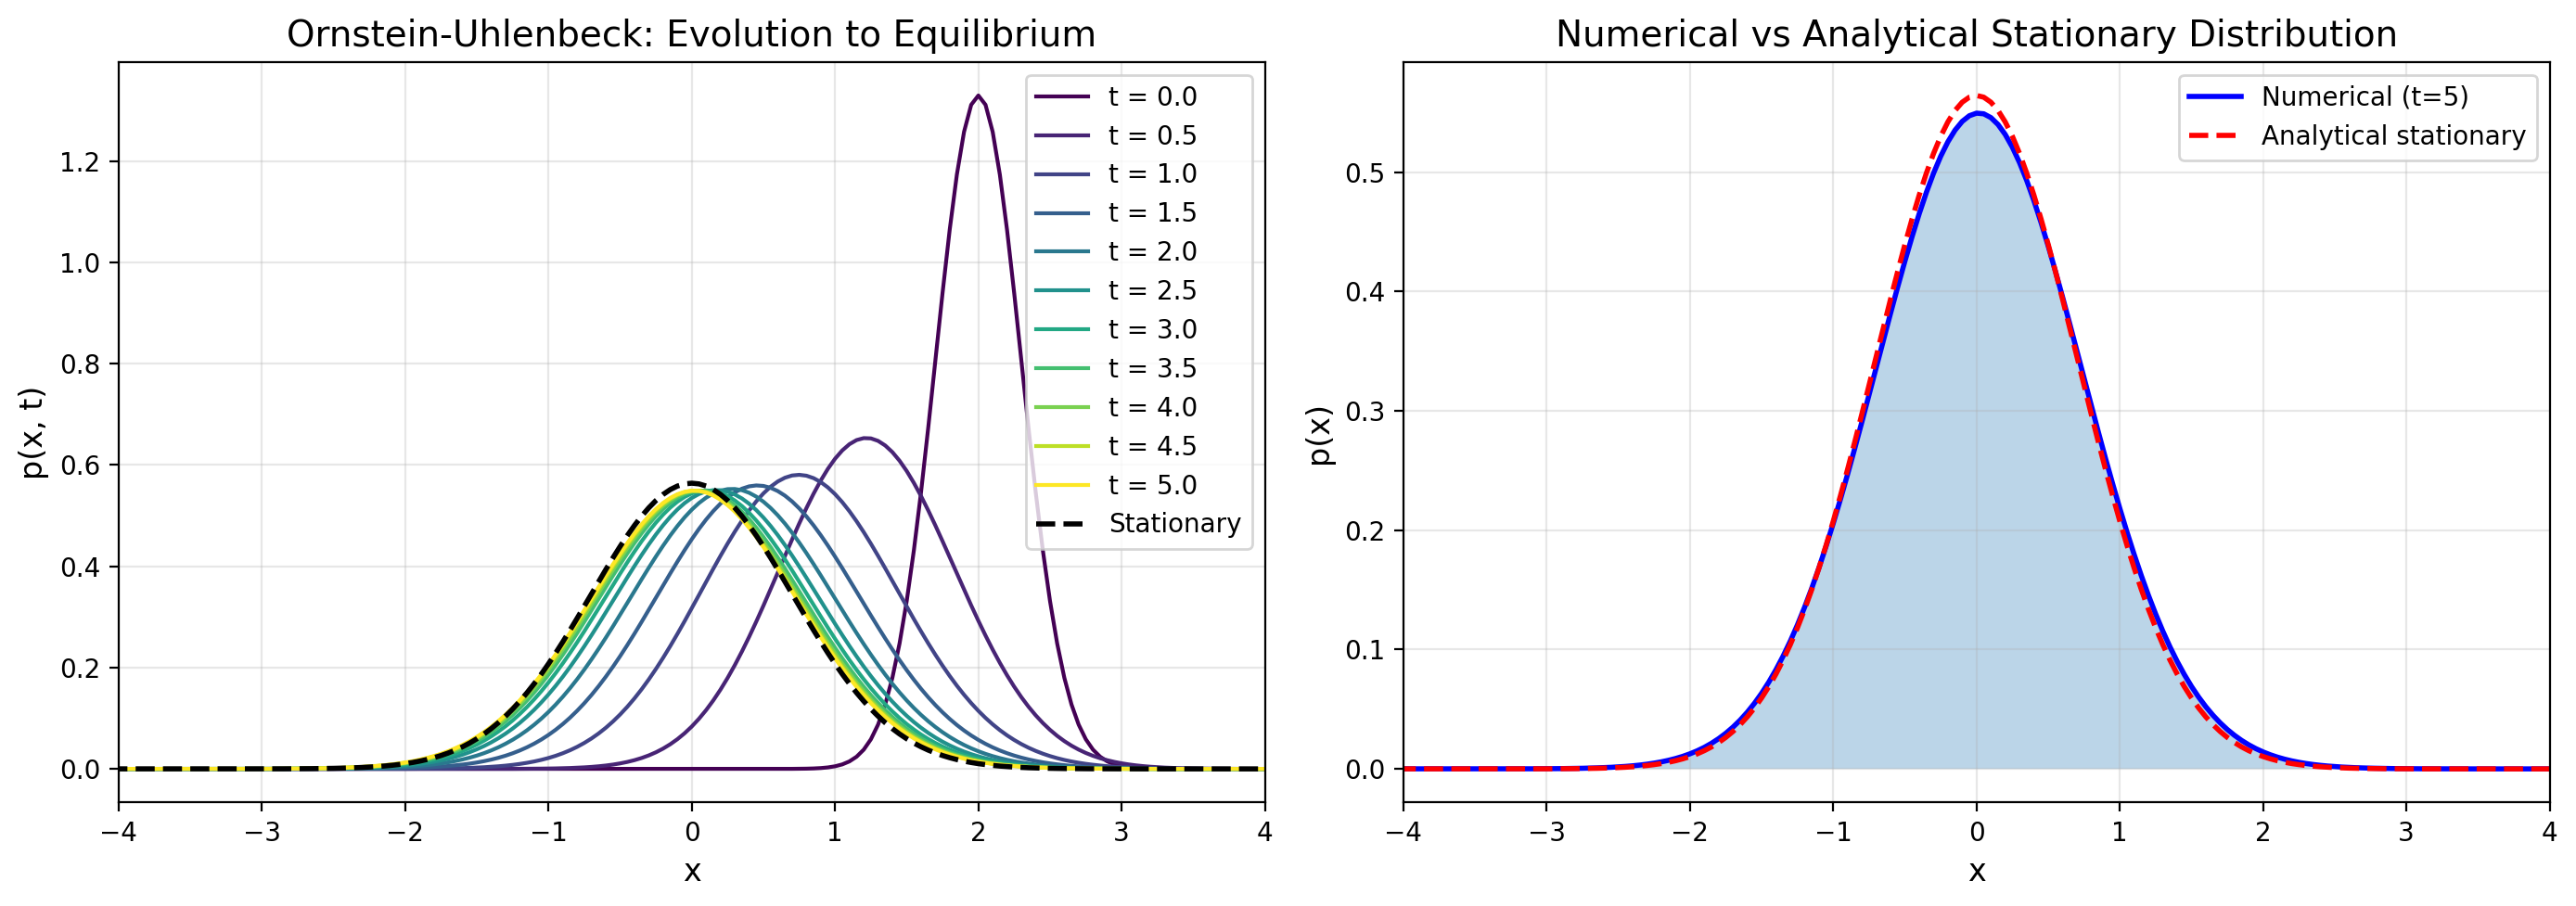


L² error at t=5.0: 0.018172


In [4]:
# Analytical stationary distribution for OU process
def stationary_ou(x):
    """Stationary distribution for OU process."""
    var_inf = sigma_ou**2 / (2 * theta_ou)
    return np.exp(-(x - mu_ou)**2 / (2 * var_inf)) / np.sqrt(2 * np.pi * var_inf)

p_stationary = stationary_ou(solver_ou.x)

# Plot evolution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Time evolution
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(t_ou)))
for i, (t, p) in enumerate(zip(t_ou, p_ou)):
    ax1.plot(solver_ou.x, p, color=colors[i], label=f't = {t:.1f}', linewidth=1.5)
ax1.plot(solver_ou.x, p_stationary, 'k--', linewidth=2, label='Stationary')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('p(x, t)', fontsize=12)
ax1.set_title('Ornstein-Uhlenbeck: Evolution to Equilibrium', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-4, 4)

# Right: Comparison with analytical
ax2 = axes[1]
ax2.plot(solver_ou.x, p_ou[-1], 'b-', linewidth=2, label='Numerical (t=5)')
ax2.plot(solver_ou.x, p_stationary, 'r--', linewidth=2, label='Analytical stationary')
ax2.fill_between(solver_ou.x, p_ou[-1], alpha=0.3)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('p(x)', fontsize=12)
ax2.set_title('Numerical vs Analytical Stationary Distribution', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-4, 4)

plt.tight_layout()
plt.savefig('ou_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute L2 error
l2_error = np.sqrt(np.trapezoid((p_ou[-1] - p_stationary)**2, solver_ou.x))
print(f"\nL² error at t={t_final}: {l2_error:.6f}")

## Example 2: Double-Well Potential (Bistable System)

Consider a particle in a double-well potential:

$$V(x) = \frac{1}{4}x^4 - \frac{1}{2}x^2$$

The drift is given by the negative gradient of the potential:

$$\mu(x) = -V'(x) = x - x^3$$

This system has stable equilibria at $x = \pm 1$ and an unstable equilibrium at $x = 0$.

In [5]:
# Double-well potential parameters
sigma_dw = 0.7  # Noise intensity

def potential(x):
    """Double-well potential V(x) = x⁴/4 - x²/2"""
    return 0.25 * x**4 - 0.5 * x**2

def drift_double_well(x):
    """Drift μ(x) = -V'(x) = x - x³"""
    return x - x**3

def diffusion_double_well(x):
    """Constant diffusion D = σ²"""
    return sigma_dw**2 * np.ones_like(x)

# Spatial grid
x_min_dw, x_max_dw = -3.0, 3.0
nx_dw = 301

# Create solver
solver_dw = FokkerPlanckSolver(x_min_dw, x_max_dw, nx_dw, drift_double_well, diffusion_double_well)

# Initial condition: Gaussian in left well
x0_dw = -1.0
sigma0_dw = 0.3
p0_dw = np.exp(-(solver_dw.x - x0_dw)**2 / (2 * sigma0_dw**2))
p0_dw = p0_dw / np.trapezoid(p0_dw, solver_dw.x)

# Solve for longer time to see barrier crossing
t_final_dw = 10.0
nt_dw = 2000
t_dw, p_dw = solver_dw.solve(p0_dw, t_final_dw, nt_dw, store_every=200)

print(f"Double-well simulation complete.")
print(f"Time points stored: {len(t_dw)}")

Double-well simulation complete.
Time points stored: 11


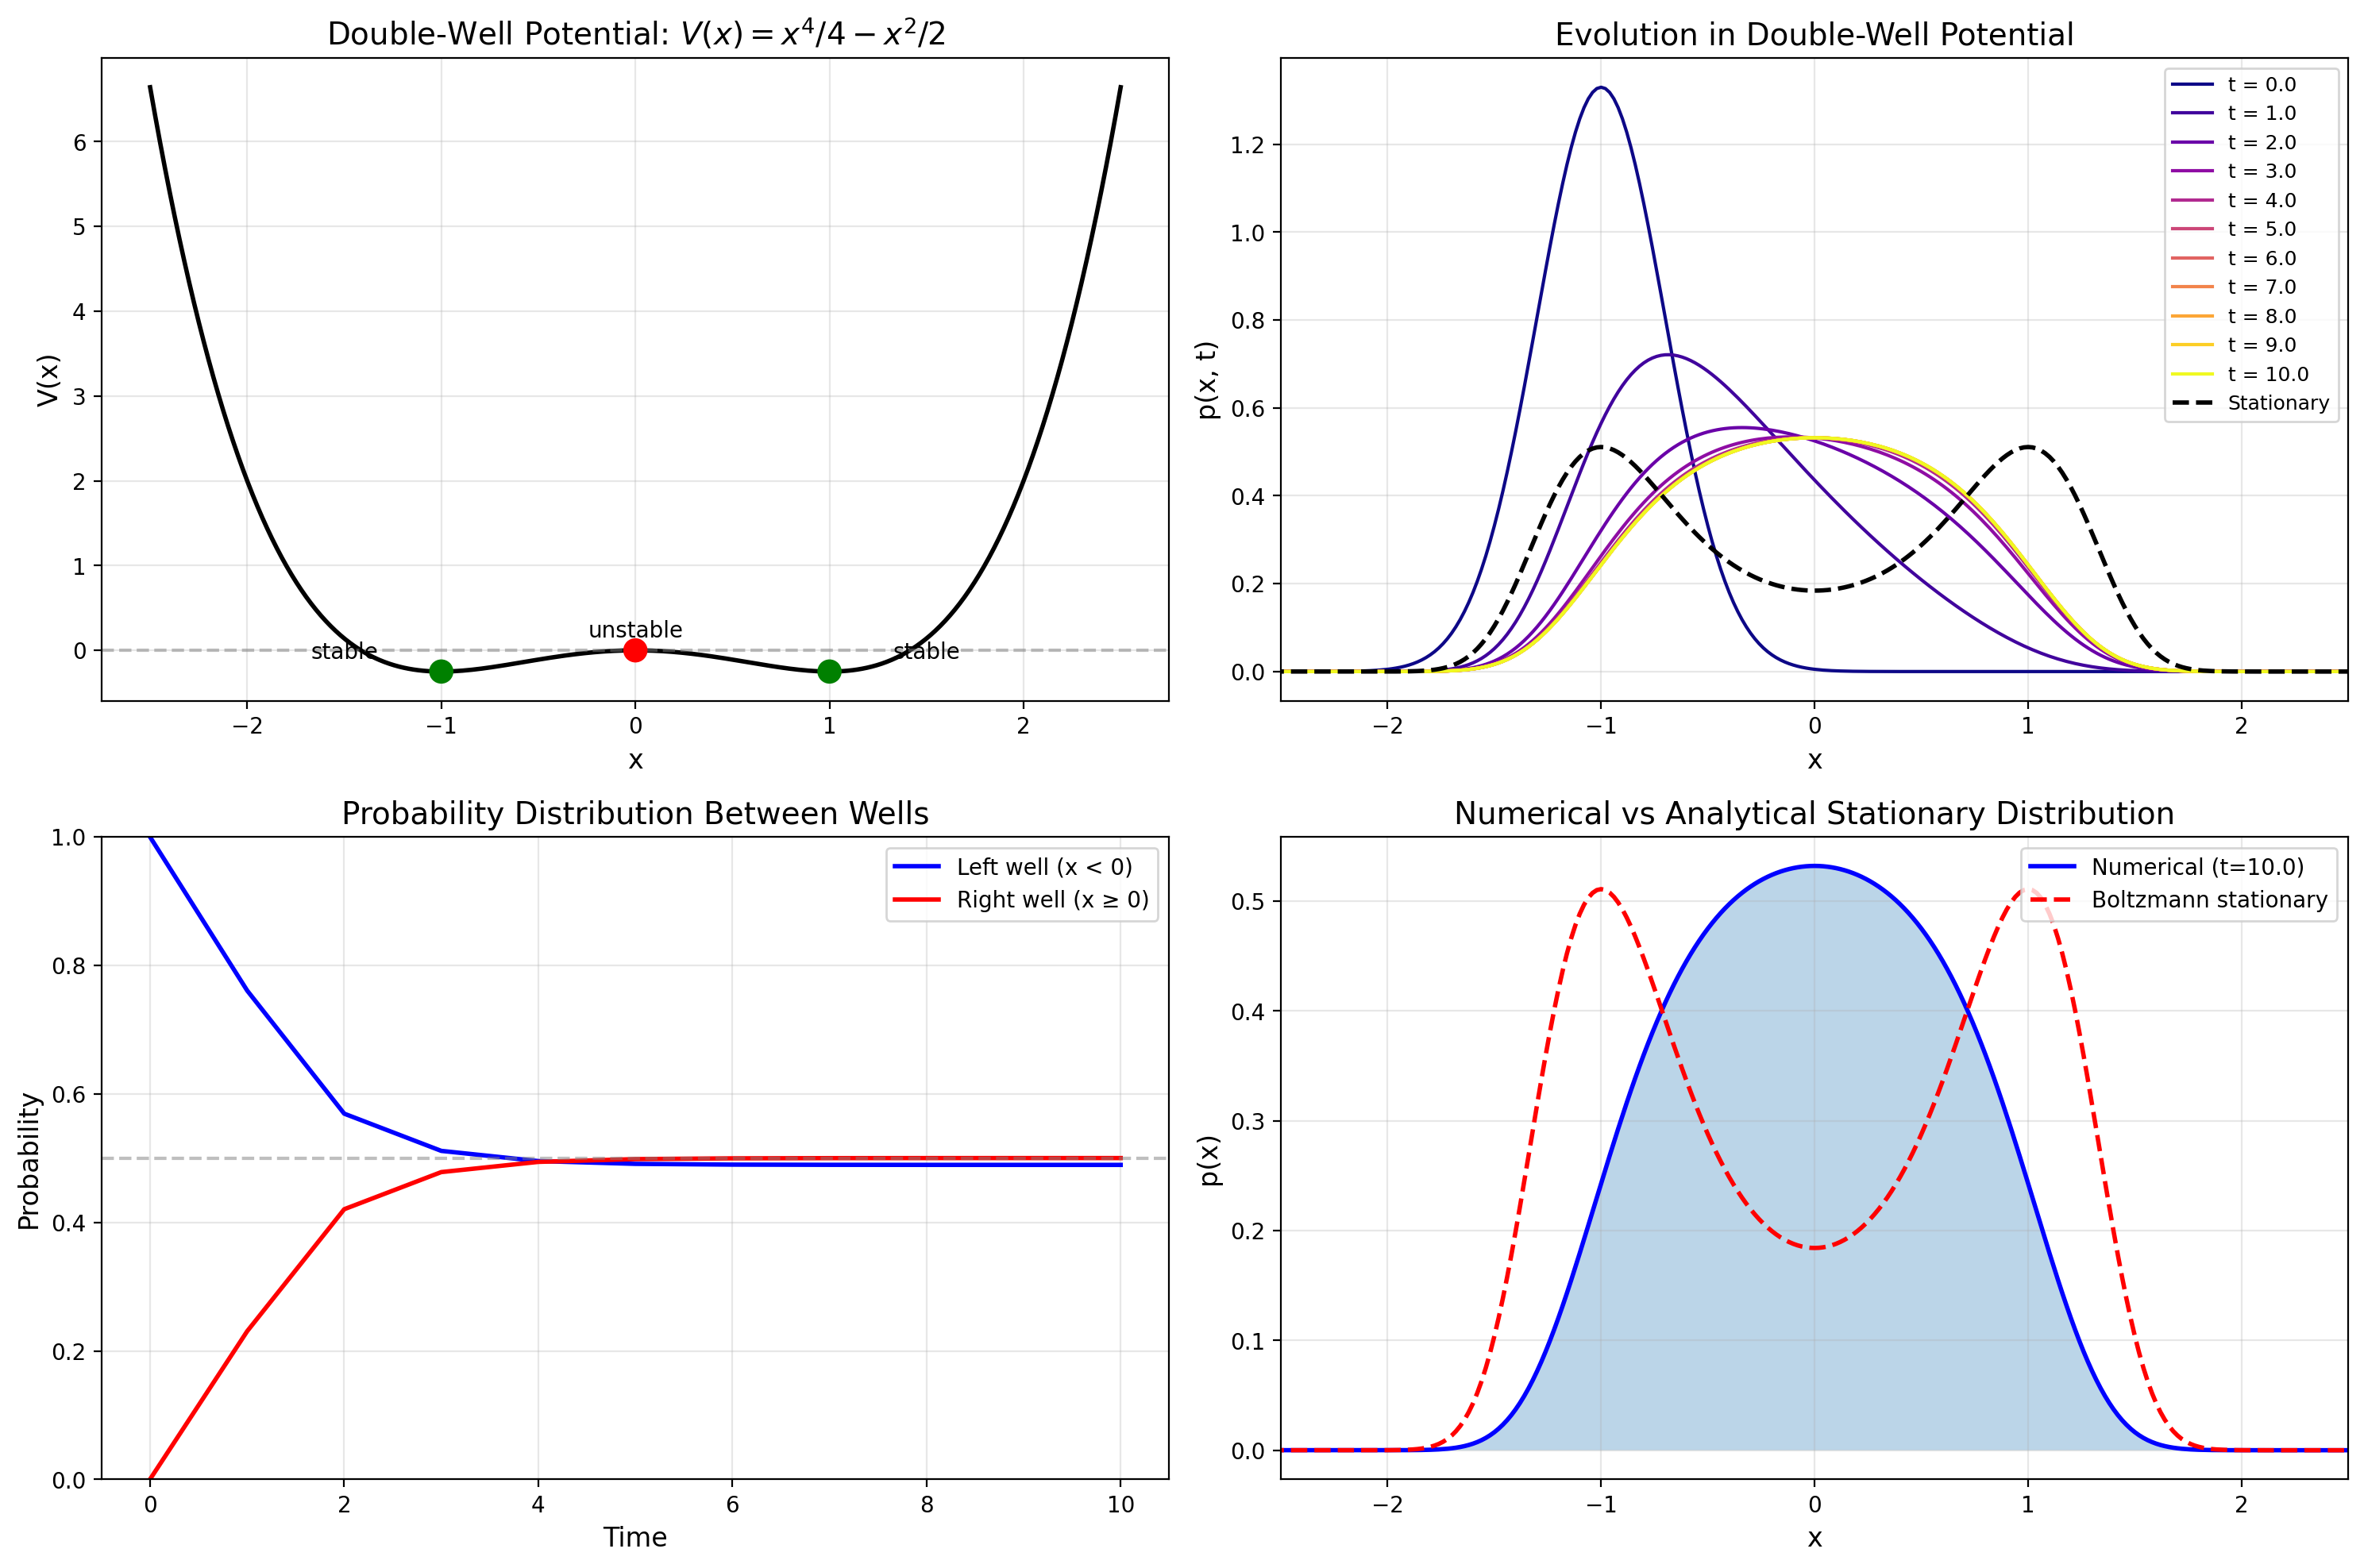


L² error at t=10.0: 0.417616


In [6]:
# Analytical stationary distribution (Boltzmann distribution)
def stationary_double_well(x):
    """Boltzmann distribution: p ∝ exp(-2V(x)/σ²)"""
    V = potential(x)
    p = np.exp(-2 * V / sigma_dw**2)
    return p / np.trapezoid(p, x)

p_stat_dw = stationary_double_well(solver_dw.x)

# Create comprehensive visualization
fig = plt.figure(figsize=(15, 10))

# Subplot 1: Potential landscape
ax1 = fig.add_subplot(2, 2, 1)
x_pot = np.linspace(-2.5, 2.5, 200)
ax1.plot(x_pot, potential(x_pot), 'k-', linewidth=2)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.scatter([-1, 0, 1], [potential(-1), potential(0), potential(1)], 
            c=['green', 'red', 'green'], s=100, zorder=5)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('V(x)', fontsize=12)
ax1.set_title('Double-Well Potential: $V(x) = x^4/4 - x^2/2$', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.annotate('stable', xy=(-1, potential(-1)), xytext=(-1.5, -0.1),
             fontsize=10, ha='center')
ax1.annotate('unstable', xy=(0, potential(0)), xytext=(0, 0.15),
             fontsize=10, ha='center')
ax1.annotate('stable', xy=(1, potential(1)), xytext=(1.5, -0.1),
             fontsize=10, ha='center')

# Subplot 2: Time evolution
ax2 = fig.add_subplot(2, 2, 2)
colors_dw = plt.cm.plasma(np.linspace(0, 1, len(t_dw)))
for i, (t, p) in enumerate(zip(t_dw, p_dw)):
    ax2.plot(solver_dw.x, p, color=colors_dw[i], label=f't = {t:.1f}', linewidth=1.5)
ax2.plot(solver_dw.x, p_stat_dw, 'k--', linewidth=2, label='Stationary')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('p(x, t)', fontsize=12)
ax2.set_title('Evolution in Double-Well Potential', fontsize=14)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-2.5, 2.5)

# Subplot 3: Probability in each well over time
ax3 = fig.add_subplot(2, 2, 3)
prob_left = [np.trapezoid(p[solver_dw.x < 0], solver_dw.x[solver_dw.x < 0]) for p in p_dw]
prob_right = [np.trapezoid(p[solver_dw.x >= 0], solver_dw.x[solver_dw.x >= 0]) for p in p_dw]

ax3.plot(t_dw, prob_left, 'b-', linewidth=2, label='Left well (x < 0)')
ax3.plot(t_dw, prob_right, 'r-', linewidth=2, label='Right well (x ≥ 0)')
ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Probability', fontsize=12)
ax3.set_title('Probability Distribution Between Wells', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# Subplot 4: Final vs stationary
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(solver_dw.x, p_dw[-1], 'b-', linewidth=2, label=f'Numerical (t={t_final_dw})')
ax4.plot(solver_dw.x, p_stat_dw, 'r--', linewidth=2, label='Boltzmann stationary')
ax4.fill_between(solver_dw.x, p_dw[-1], alpha=0.3)
ax4.set_xlabel('x', fontsize=12)
ax4.set_ylabel('p(x)', fontsize=12)
ax4.set_title('Numerical vs Analytical Stationary Distribution', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-2.5, 2.5)

plt.tight_layout()
plt.savefig('double_well.png', dpi=150, bbox_inches='tight')
plt.show()

l2_error_dw = np.sqrt(np.trapezoid((p_dw[-1] - p_stat_dw)**2, solver_dw.x))
print(f"\nL² error at t={t_final_dw}: {l2_error_dw:.6f}")

## Example 3: State-Dependent Diffusion (Geometric Brownian Motion)

For financial applications, consider **Geometric Brownian Motion** (GBM) used in the Black-Scholes model:

$$dS_t = \mu S_t\, dt + \sigma S_t\, dW_t$$

The Fokker-Planck equation for GBM is:

$$\frac{\partial p}{\partial t} = -\frac{\partial}{\partial S}(\mu S\, p) + \frac{\sigma^2}{2}\frac{\partial^2}{\partial S^2}(S^2\, p)$$

The solution is a **log-normal distribution**.

In [7]:
# GBM parameters
mu_gbm = 0.1      # Drift rate
sigma_gbm = 0.3   # Volatility
S0 = 100.0        # Initial stock price

def drift_gbm(S):
    """Drift for GBM: μS"""
    return mu_gbm * S

def diffusion_gbm(S):
    """Diffusion for GBM: σ²S²"""
    return sigma_gbm**2 * S**2

# Spatial grid (positive values only for stock prices)
S_min, S_max = 1.0, 300.0
nS = 301

# Create solver
solver_gbm = FokkerPlanckSolver(S_min, S_max, nS, drift_gbm, diffusion_gbm)

# Initial condition: narrow distribution around S0
sigma0_gbm = 5.0
p0_gbm = np.exp(-(solver_gbm.x - S0)**2 / (2 * sigma0_gbm**2))
p0_gbm = p0_gbm / np.trapezoid(p0_gbm, solver_gbm.x)

# Solve
t_final_gbm = 2.0  # 2 years
nt_gbm = 2000
t_gbm, p_gbm = solver_gbm.solve(p0_gbm, t_final_gbm, nt_gbm, store_every=400)

print(f"GBM simulation complete.")
print(f"Time points stored: {len(t_gbm)}")

GBM simulation complete.
Time points stored: 6


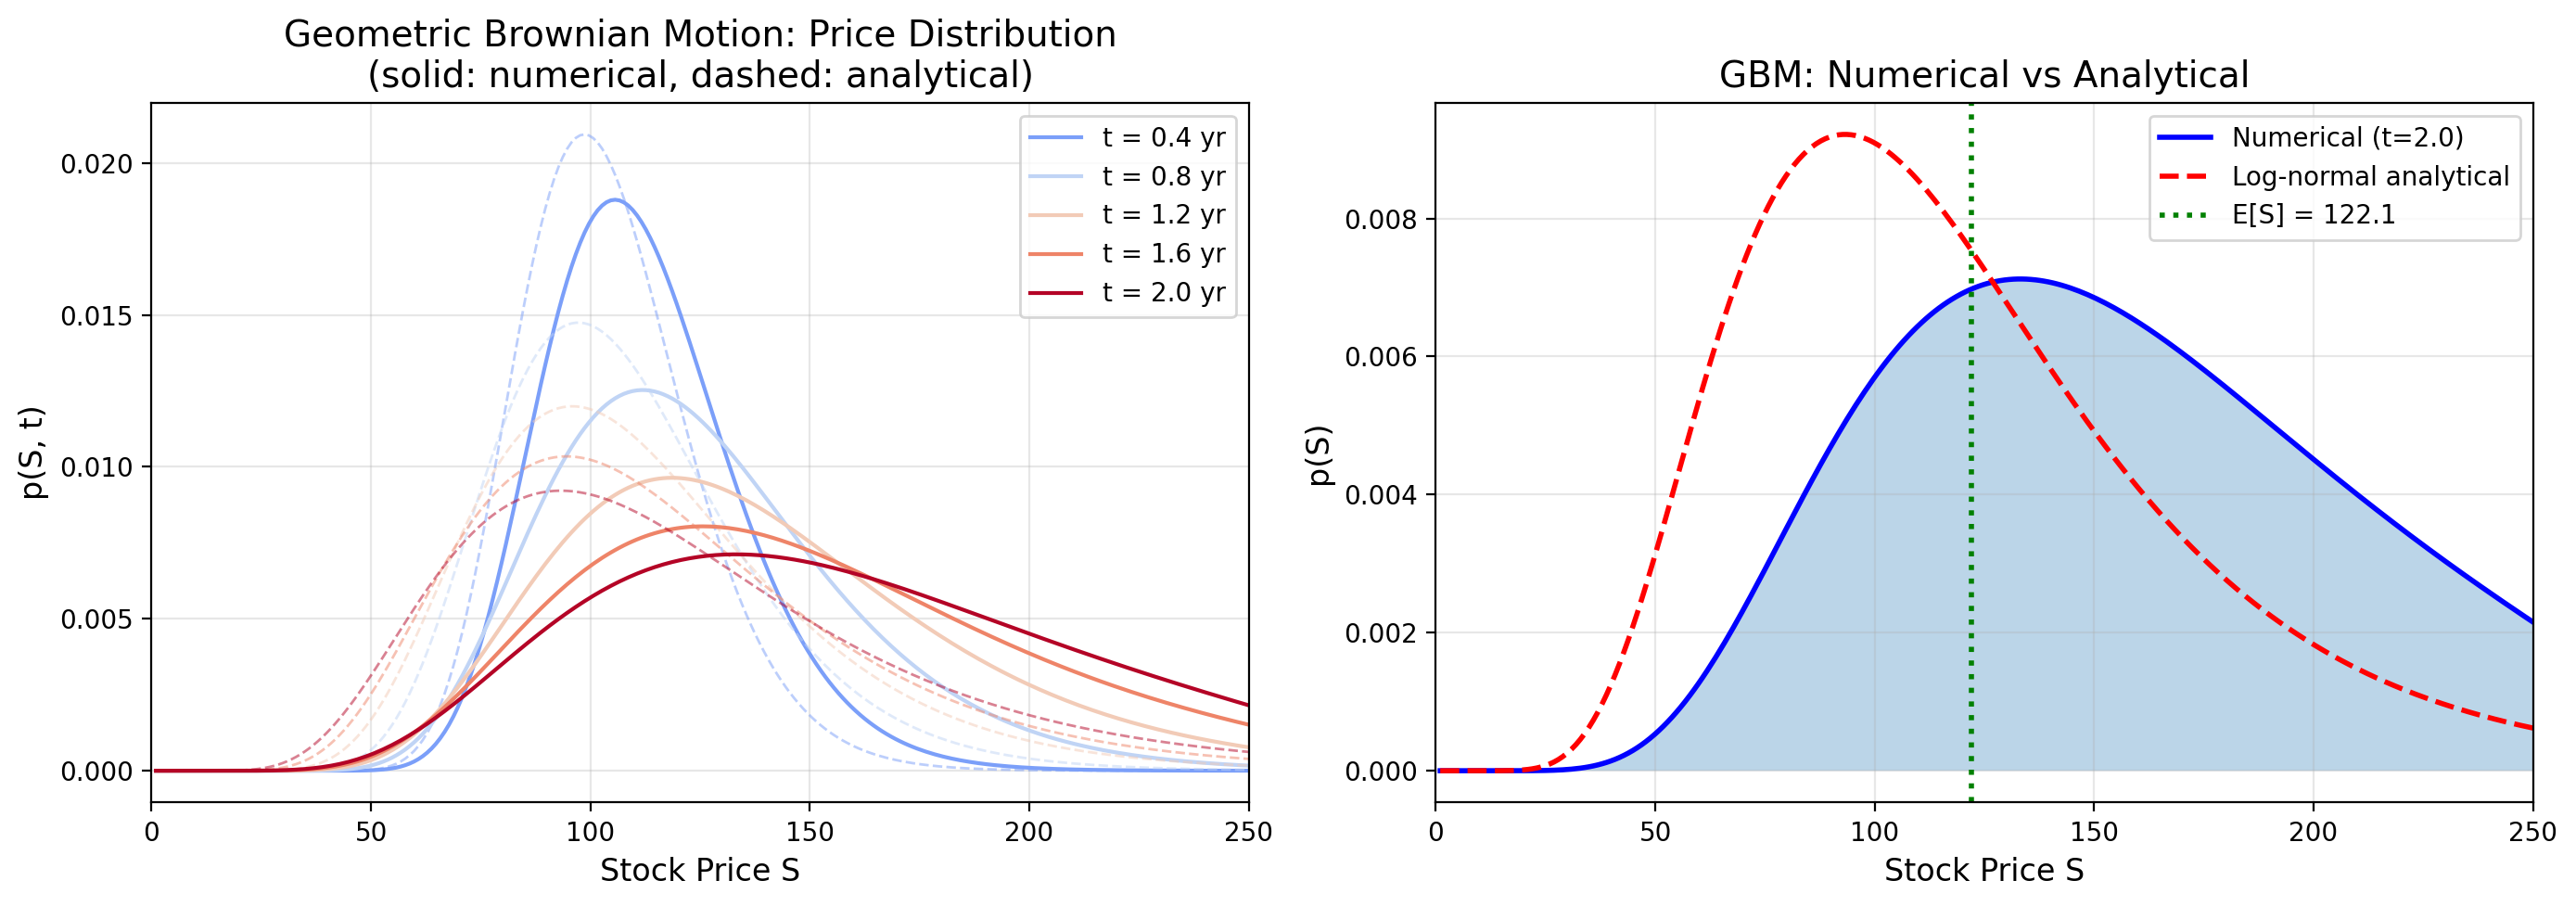

In [8]:
# Analytical log-normal distribution for GBM
def lognormal_pdf(S, t, S0, mu, sigma):
    """Log-normal PDF for GBM at time t starting from S0."""
    if t <= 0:
        return np.zeros_like(S)
    
    # Parameters of the log-normal distribution
    m = np.log(S0) + (mu - 0.5 * sigma**2) * t
    s = sigma * np.sqrt(t)
    
    pdf = np.zeros_like(S)
    mask = S > 0
    pdf[mask] = (1 / (S[mask] * s * np.sqrt(2 * np.pi))) * \
                np.exp(-(np.log(S[mask]) - m)**2 / (2 * s**2))
    return pdf

# Plot GBM results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Time evolution
ax1 = axes[0]
colors_gbm = plt.cm.coolwarm(np.linspace(0, 1, len(t_gbm)))
for i, (t, p) in enumerate(zip(t_gbm, p_gbm)):
    if t > 0:
        ax1.plot(solver_gbm.x, p, color=colors_gbm[i], label=f't = {t:.1f} yr', linewidth=1.5)
        # Analytical comparison
        p_analytical = lognormal_pdf(solver_gbm.x, t, S0, mu_gbm, sigma_gbm)
        ax1.plot(solver_gbm.x, p_analytical, '--', color=colors_gbm[i], alpha=0.5, linewidth=1)

ax1.set_xlabel('Stock Price S', fontsize=12)
ax1.set_ylabel('p(S, t)', fontsize=12)
ax1.set_title('Geometric Brownian Motion: Price Distribution\n(solid: numerical, dashed: analytical)', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 250)

# Right: Final comparison
ax2 = axes[1]
t_final_plot = t_gbm[-1]
p_analytical_final = lognormal_pdf(solver_gbm.x, t_final_plot, S0, mu_gbm, sigma_gbm)
ax2.plot(solver_gbm.x, p_gbm[-1], 'b-', linewidth=2, label=f'Numerical (t={t_final_plot:.1f})')
ax2.plot(solver_gbm.x, p_analytical_final, 'r--', linewidth=2, label='Log-normal analytical')
ax2.fill_between(solver_gbm.x, p_gbm[-1], alpha=0.3)

# Mark expected value
E_S = S0 * np.exp(mu_gbm * t_final_plot)
ax2.axvline(x=E_S, color='green', linestyle=':', linewidth=2, label=f'E[S] = {E_S:.1f}')

ax2.set_xlabel('Stock Price S', fontsize=12)
ax2.set_ylabel('p(S)', fontsize=12)
ax2.set_title('GBM: Numerical vs Analytical', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 250)

plt.tight_layout()
plt.savefig('gbm_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary and Key Insights

### The Kolmogorov Forward Equation:

$$\frac{\partial p}{\partial t} = -\frac{\partial}{\partial x}(\mu\, p) + \frac{1}{2}\frac{\partial^2}{\partial x^2}(D\, p)$$

**Key Properties:**

1. **Conservation of probability**: Total probability is conserved under appropriate boundary conditions

2. **Equilibrium states**: Stationary solutions ($\partial p/\partial t = 0$) satisfy:
   $$-\frac{d}{dx}(\mu\, p) + \frac{1}{2}\frac{d^2}{dx^2}(D\, p) = 0$$

3. **Detailed balance**: For gradient systems ($\mu = -V'$), the Boltzmann distribution is stationary:
   $$p_\infty(x) \propto \exp\left(-\frac{2V(x)}{D}\right)$$

4. **H-theorem**: Under suitable conditions, the relative entropy (KL divergence) from the stationary distribution decreases monotonically.

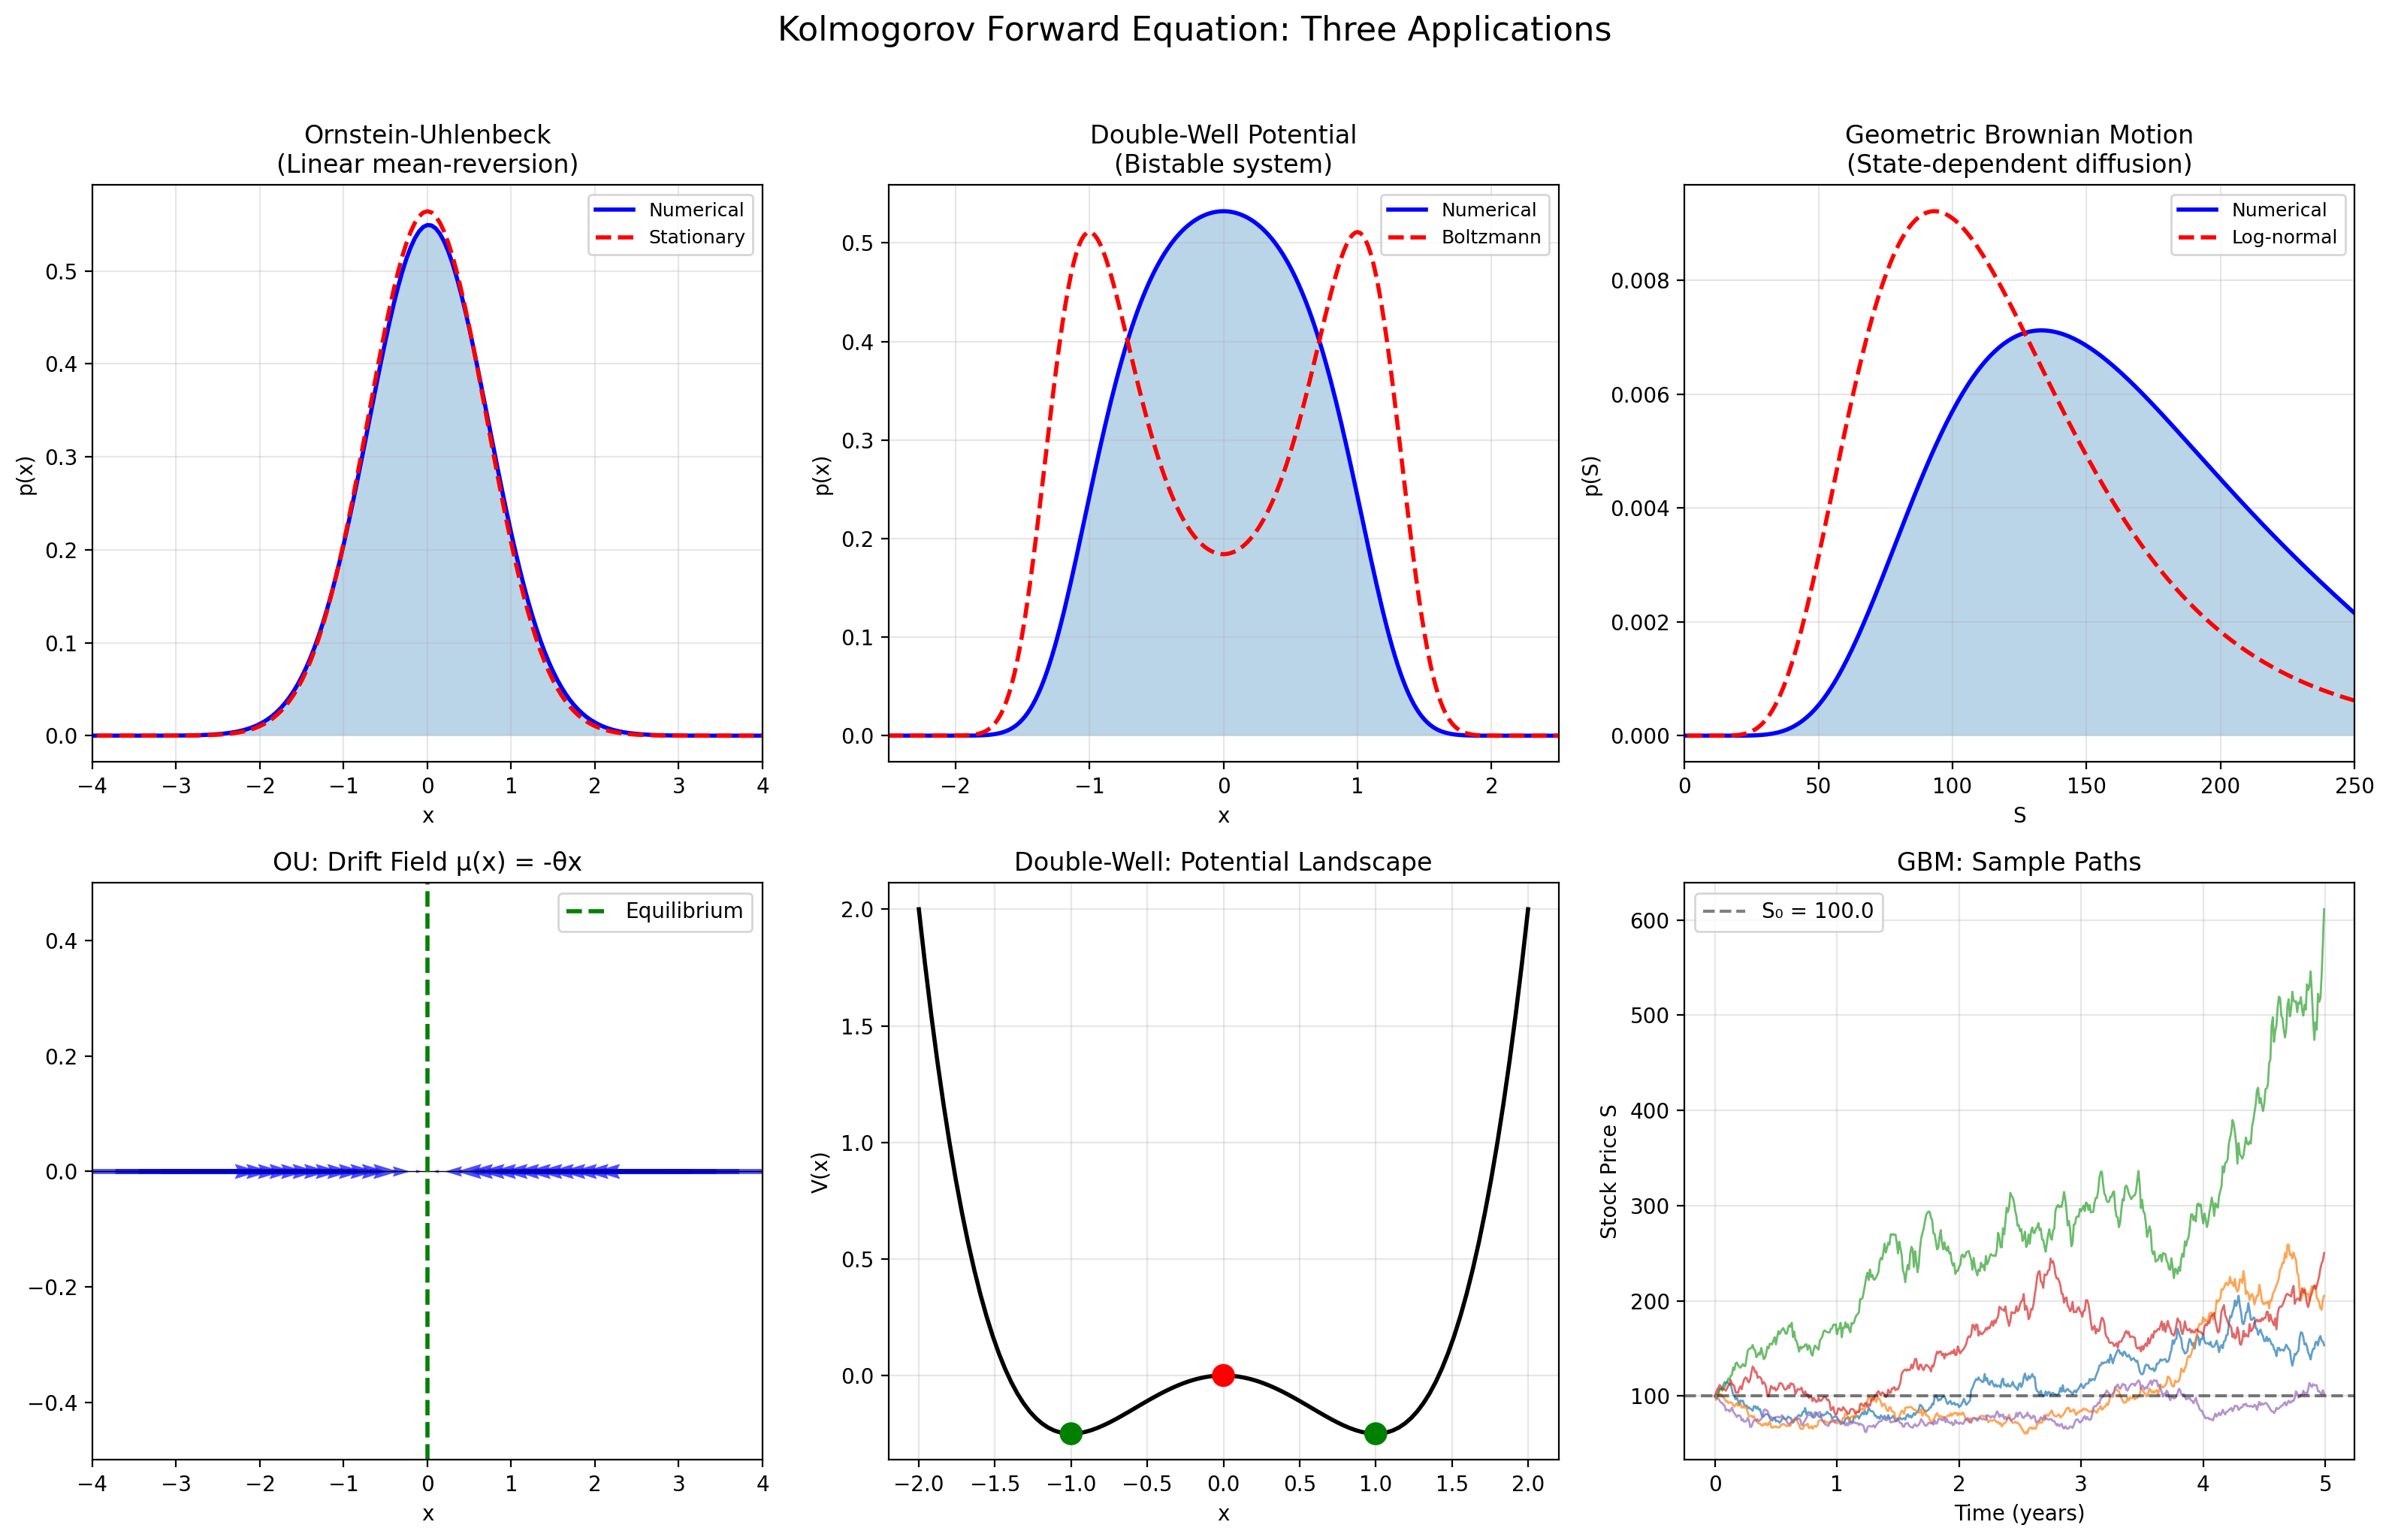


Final plot saved to 'plot.png'


In [9]:
# Create final summary plot combining all examples
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: Final distributions
# OU Process
ax = axes[0, 0]
ax.plot(solver_ou.x, p_ou[-1], 'b-', linewidth=2, label='Numerical')
ax.plot(solver_ou.x, p_stationary, 'r--', linewidth=2, label='Stationary')
ax.fill_between(solver_ou.x, p_ou[-1], alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title('Ornstein-Uhlenbeck\n(Linear mean-reversion)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-4, 4)

# Double-well
ax = axes[0, 1]
ax.plot(solver_dw.x, p_dw[-1], 'b-', linewidth=2, label='Numerical')
ax.plot(solver_dw.x, p_stat_dw, 'r--', linewidth=2, label='Boltzmann')
ax.fill_between(solver_dw.x, p_dw[-1], alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title('Double-Well Potential\n(Bistable system)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-2.5, 2.5)

# GBM
ax = axes[0, 2]
ax.plot(solver_gbm.x, p_gbm[-1], 'b-', linewidth=2, label='Numerical')
ax.plot(solver_gbm.x, p_analytical_final, 'r--', linewidth=2, label='Log-normal')
ax.fill_between(solver_gbm.x, p_gbm[-1], alpha=0.3)
ax.set_xlabel('S')
ax.set_ylabel('p(S)')
ax.set_title('Geometric Brownian Motion\n(State-dependent diffusion)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 250)

# Row 2: Physical context
# Drift field for OU
ax = axes[1, 0]
x_field = np.linspace(-4, 4, 30)
mu_field = drift_ou(x_field)
ax.quiver(x_field, np.zeros_like(x_field), mu_field, np.zeros_like(x_field),
          angles='xy', scale_units='xy', scale=2, color='blue', alpha=0.7)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Equilibrium')
ax.set_xlabel('x')
ax.set_title('OU: Drift Field μ(x) = -θx', fontsize=12)
ax.set_xlim(-4, 4)
ax.set_ylim(-0.5, 0.5)
ax.legend()

# Potential for double-well
ax = axes[1, 1]
x_pot = np.linspace(-2, 2, 100)
V_pot = potential(x_pot)
ax.plot(x_pot, V_pot, 'k-', linewidth=2)
ax.scatter([-1, 0, 1], [potential(-1), potential(0), potential(1)],
           c=['green', 'red', 'green'], s=100, zorder=5)
ax.set_xlabel('x')
ax.set_ylabel('V(x)')
ax.set_title('Double-Well: Potential Landscape', fontsize=12)
ax.grid(True, alpha=0.3)

# Sample paths simulation for illustration
ax = axes[1, 2]
np.random.seed(42)
n_paths = 5
n_steps = 500
dt_sim = 0.01
t_sim = np.arange(n_steps) * dt_sim

for _ in range(n_paths):
    S = np.zeros(n_steps)
    S[0] = S0
    for i in range(1, n_steps):
        dW = np.sqrt(dt_sim) * np.random.randn()
        S[i] = S[i-1] + mu_gbm * S[i-1] * dt_sim + sigma_gbm * S[i-1] * dW
        S[i] = max(S[i], 0.01)  # Ensure positivity
    ax.plot(t_sim, S, alpha=0.7, linewidth=1)

ax.axhline(y=S0, color='black', linestyle='--', alpha=0.5, label=f'S₀ = {S0}')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Stock Price S')
ax.set_title('GBM: Sample Paths', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Kolmogorov Forward Equation: Three Applications', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('kolmogorov_forward_equation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFinal plot saved to 'plot.png'")

## Conclusion

The **Kolmogorov Forward Equation** (Fokker-Planck equation) provides a powerful framework for understanding the probabilistic evolution of stochastic systems. Key takeaways:

1. **Deterministic description of randomness**: While individual trajectories are random, their probability distribution evolves deterministically

2. **Drift vs. diffusion balance**: The competition between advective transport (drift) and spreading (diffusion) determines the system behavior

3. **Universal applicability**: From Brownian motion to financial markets to biological systems, the equation provides a unified mathematical framework

4. **Numerical methods**: Finite difference schemes with appropriate stability (Crank-Nicolson) enable accurate simulation of complex systems

The examples demonstrated:
- **Ornstein-Uhlenbeck**: Linear mean-reversion leading to Gaussian equilibrium
- **Double-well potential**: Bistability and barrier crossing dynamics
- **Geometric Brownian Motion**: State-dependent diffusion yielding log-normal distributions